# Explaining Model Predictions with Interpretability Techniques

In this notebook, we will explore various methods to explain the predictions of a Convolutional Neural Network (CNN) trained to classify images from the "Dogs vs. Cats" dataset. Understanding how a model makes predictions is crucial for improving its performance and ensuring transparency.

We will implement and visualize three key explainer techniques:
1. **Integrated Gradients**
2. **Grad-CAM (Gradient-weighted Class Activation Mapping)**

These methods help highlight the most important parts of the input image that contributed to the final decision made by the model.


In [1]:
# import os
# os.environ['LD_LIBRARY_PATH'] = '/workspaces/artificial_intelligence/.venv/lib/python3.11/site-packages/tensorrt_libs'

import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

import tensorflow as tf
import keras
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [2]:
!pip install datasets # Install the 'datasets' library
from datasets import load_dataset

ds = load_dataset("pantelism/cats-vs-dogs")

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dogs-vs-cats-subset.zip:   0%|          | 0.00/90.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [3]:
type(ds)
# convert this to zip file
ds.save_to_disk('dogs-vs-cats-subset')

Saving the dataset (0/1 shards):   0%|          | 0/4000 [00:00<?, ? examples/s]

In [91]:
import os
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def setup_directories(base_dir):
    """Set up directory structure for the dataset."""
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')

    # Remove existing directory if it exists
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)

    # Create new directories
    for dir in [os.path.join(train_dir, lbl) for lbl in ['cats', 'dogs']] + [os.path.join(test_dir, lbl) for lbl in ['cats', 'dogs']]:
        os.makedirs(dir, exist_ok=True)

    return train_dir, test_dir

def save_images(dataset, directory):
    """Save images to the specified directory."""
    for i, item in tqdm(enumerate(dataset), total=len(dataset), desc=f"Saving images to {directory}"):
        label = 'cats' if item['label'] == 0 else 'dogs'
        item['image'].save(os.path.join(directory, label, f"{label}_{i}.jpg"))

def balance_dataset(image_paths, labels, min_samples=None):
    """Balance the dataset by undersampling the majority class."""
    cat_paths = [path for path, label in zip(image_paths, labels) if label == 0]
    dog_paths = [path for path, label in zip(image_paths, labels) if label == 1]

    if min_samples is None:
        min_samples = min(len(cat_paths), len(dog_paths))

    np.random.seed(42)
    balanced_cat_paths = np.random.choice(cat_paths, min_samples, replace=False)
    balanced_dog_paths = np.random.choice(dog_paths, min_samples, replace=False)

    balanced_paths = np.concatenate([balanced_cat_paths, balanced_dog_paths])
    balanced_labels = np.array([0] * min_samples + [1] * min_samples)

    return balanced_paths, balanced_labels

def prepare_dataset(ds, base_dir, test_size=0.2):
    """Prepare and balance the dataset."""
    train_dir, test_dir = setup_directories(base_dir)

    # Save all images
    for split in ds.keys():
        save_images(ds[split], train_dir if split == 'train' else test_dir)

    # Get all image paths and labels
    cat_paths = [os.path.join(train_dir, 'cats', fname) for fname in os.listdir(os.path.join(train_dir, 'cats'))]
    dog_paths = [os.path.join(train_dir, 'dogs', fname) for fname in os.listdir(os.path.join(train_dir, 'dogs'))]
    image_paths = cat_paths + dog_paths
    labels = [0] * len(cat_paths) + [1] * len(dog_paths)

    # Balance the dataset
    balanced_paths, balanced_labels = balance_dataset(image_paths, labels)

    # Split into train and test
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        balanced_paths, balanced_labels, test_size=test_size, stratify=balanced_labels, random_state=42
    )

    # Move test images to test directory
    for path, label in zip(test_paths, test_labels):
        lbl_folder = 'cats' if label == 0 else 'dogs'
        shutil.move(path, os.path.join(test_dir, lbl_folder))

    return train_paths, test_paths, train_labels, test_labels

# Main execution
base_dir = '/content/dogs-vs-cats-subset/'
train_paths, test_paths, train_labels, test_labels = prepare_dataset(ds, base_dir)

# Print dataset summary
print(f"\nDataset Summary:")
print(f"Total images in train: {len(train_paths)}")
print(f"Total images in test: {len(test_paths)}")
print(f"\nTrain set distribution: Cats: {(train_labels == 0).mean() * 100:.2f}%, Dogs: {(train_labels == 1).mean() * 100:.2f}%")
print(f"Test set distribution: Cats: {(test_labels == 0).mean() * 100:.2f}%, Dogs: {(test_labels == 1).mean() * 100:.2f}%")

Saving images to /content/dogs-vs-cats-subset/train: 100%|██████████| 4000/4000 [04:27<00:00, 14.95it/s]


Dataset Summary:
Total images in train: 3200
Total images in test: 800

Train set distribution: Cats: 50.00%, Dogs: 50.00%
Test set distribution: Cats: 50.00%, Dogs: 50.00%


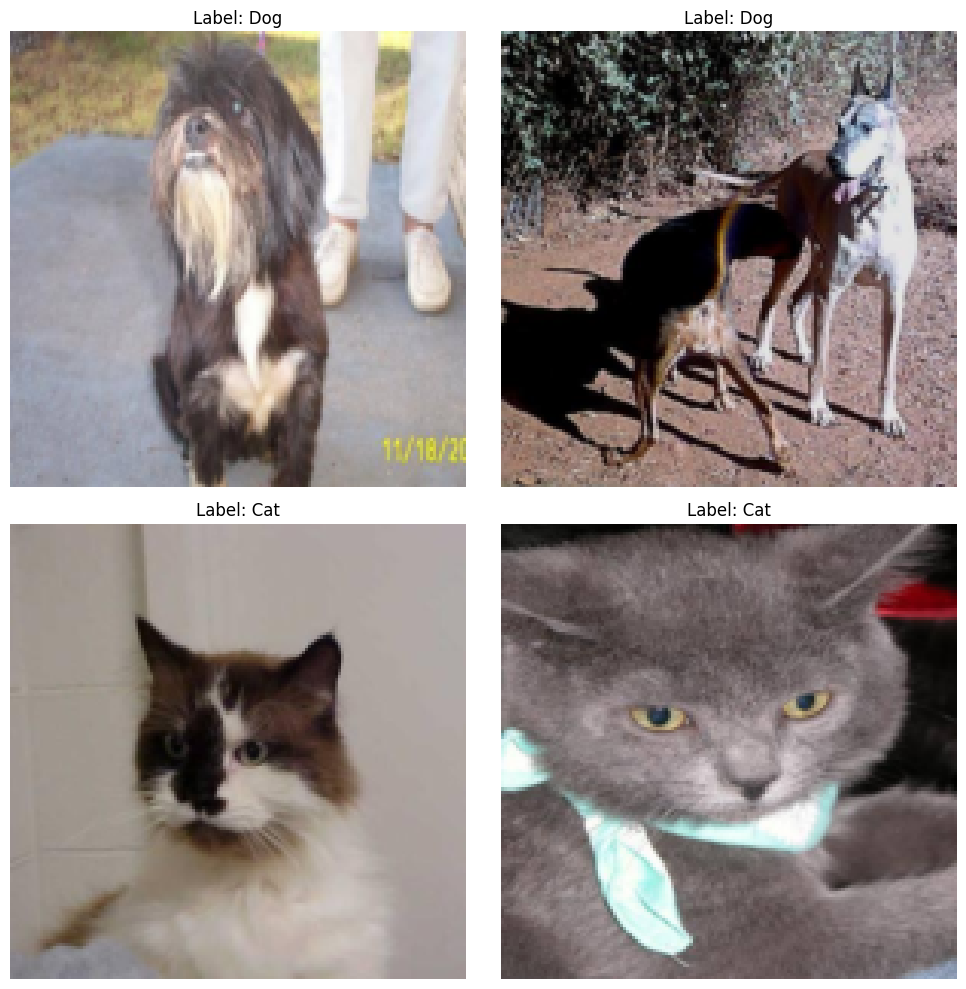

Class to index mapping: {'cats': 0, 'dogs': 1}
Epoch 1/30, Loss: 0.6825, Train Acc: 0.5648, Val Acc: 0.5687
Epoch 2/30, Loss: 0.6370, Train Acc: 0.6293, Val Acc: 0.6266
Epoch 3/30, Loss: 0.5884, Train Acc: 0.6879, Val Acc: 0.6891
Epoch 4/30, Loss: 0.5495, Train Acc: 0.7227, Val Acc: 0.7156
Epoch 5/30, Loss: 0.5189, Train Acc: 0.7441, Val Acc: 0.7109
Epoch 6/30, Loss: 0.4990, Train Acc: 0.7602, Val Acc: 0.7312
Epoch 7/30, Loss: 0.4812, Train Acc: 0.7730, Val Acc: 0.7469
Epoch 8/30, Loss: 0.4584, Train Acc: 0.7793, Val Acc: 0.7438
Epoch 9/30, Loss: 0.4310, Train Acc: 0.8008, Val Acc: 0.7625
Epoch 10/30, Loss: 0.4129, Train Acc: 0.8082, Val Acc: 0.7656
Epoch 11/30, Loss: 0.3883, Train Acc: 0.8273, Val Acc: 0.7500
Epoch 12/30, Loss: 0.3627, Train Acc: 0.8422, Val Acc: 0.7641
Epoch 13/30, Loss: 0.3381, Train Acc: 0.8484, Val Acc: 0.7516
Epoch 14/30, Loss: 0.3157, Train Acc: 0.8645, Val Acc: 0.7156
Epoch 15/30, Loss: 0.2877, Train Acc: 0.8766, Val Acc: 0.7547
Epoch 16/30, Loss: 0.2650, Train

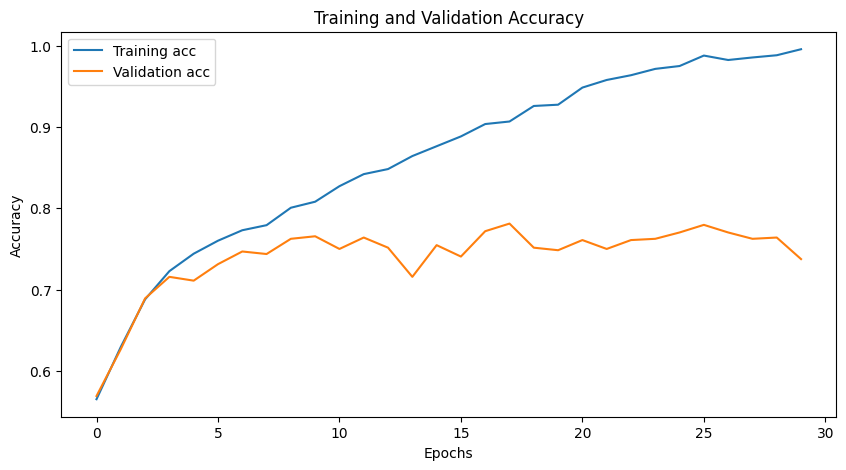

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 512)  # 150/16 = 9
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 128 * 9 * 9)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Function to visualize images
def visualize_dataset(dataset, num_images=4):
    dataloader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(dataloader))

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    for i, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Denormalize
        axs[i//2, i%2].imshow(img)
        axs[i//2, i%2].set_title(f"Label: {'Cat' if label.item() == 0 else 'Dog'}")
        axs[i//2, i%2].axis('off')

    plt.tight_layout()
    plt.show()

    print("Class to index mapping:", dataset.class_to_idx)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
train_dir = '/content/dogs-vs-cats-subset/train'
test_dir = '/content/dogs-vs-cats-subset/test'
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Visualize some images from the dataset
visualize_dataset(train_dataset)

# Split the dataset for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Load datasets into DataLoader
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
val_loader = DataLoader(val_data, batch_size=20)

# Instantiate the model and move it to the device
model = ConvNet().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 30
train_acc_history, val_acc_history = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs > 0.5  # Convert sigmoid output to binary predictions
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_acc_history.append(train_acc)

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs > 0.5
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Save model
torch.save(model.state_dict(), 'cats_and_dogs_small_1.pth')

# Plot results
epochs_range = range(num_epochs)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_history, label='Training acc')
plt.plot(epochs_range, val_acc_history, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Baseline Test Loss: 1.0533477161079645


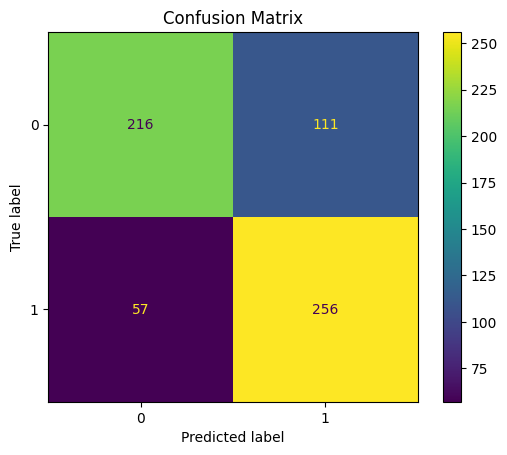

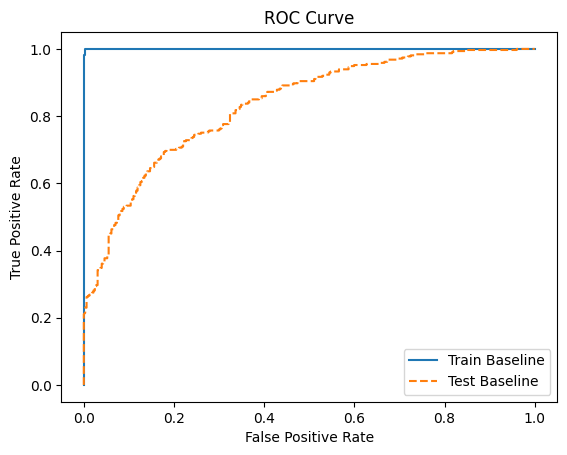

In [81]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Function to gather all predictions and labels for a dataset
def get_predictions_and_labels(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

# Get train predictions and labels
train_predictions_baseline, train_labels = get_predictions_and_labels(model, train_loader)

# Get validation (test) predictions and labels
test_predictions_baseline, test_labels = get_predictions_and_labels(model, val_loader)

# Evaluate model performance on the test dataset
def evaluate_model(model, dataloader):
    model.eval()
    loss_fn = nn.BCELoss()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

baseline_results = evaluate_model(model, val_loader)
print(f"Baseline Test Loss: {baseline_results}")

# Plot Confusion Matrix
def plot_cm(true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions > 0.5)  # Binary thresholding at 0.5
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

plot_cm(test_labels, test_predictions_baseline)

# Plot ROC curve
def plot_roc(title, true_labels, predictions, linestyle='-'):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    plt.plot(fpr, tpr, label=title, linestyle=linestyle)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

plot_roc("Train Baseline", train_labels, train_predictions_baseline)
plot_roc("Test Baseline", test_labels, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')
plt.show()


In [82]:
pf = 0  # Positive False
nf = 0  # Negative False
pt = 0  # Positive True
nt = 0  # Negative True

for i in range(len(test_labels)):
    true_label = test_labels[i]
    prediction = test_predictions_baseline[i] > 0.5  # Threshold at 0.5 for binary classification

    if true_label == 1 and prediction == 0:
        pf += 1
    elif true_label == 0 and prediction == 1:
        nf += 1
    elif true_label == 1 and prediction == 1:
        pt += 1
    elif true_label == 0 and prediction == 0:
        nt += 1


total_detections = pf + nf + pt + nt
print(f"Positive False (PF): {pf}")
print(f"Negative False (NF): {nf}")
print(f"Positive True (PT): {pt}")
print(f"Negative True (NT): {nt}")
print(f"Total Detections: {total_detections}")

Positive False (PF): 57
Negative False (NF): 111
Positive True (PT): 256
Negative True (NT): 216
Total Detections: 640


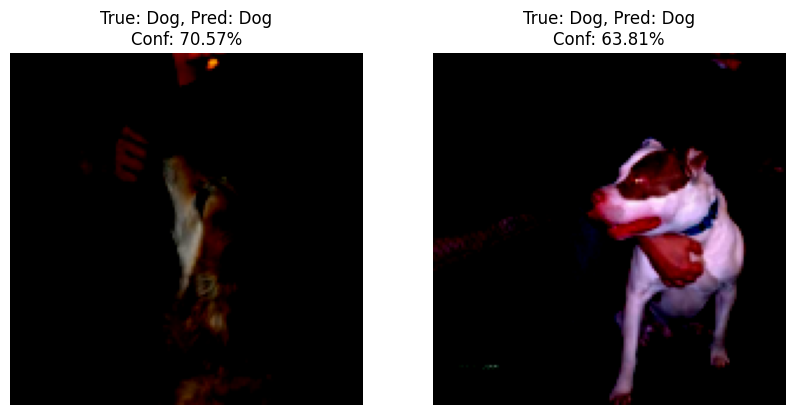

In [84]:
import random

# Function to denormalize the images if any normalization was applied (like mean/std normalization)
def denormalize(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert to HWC format
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    return img

# Function to display two random images side by side with true and predicted labels and confidence
def show_random_images_side_by_side(images, true_labels, predictions):
    num_images = len(images)
    random_indices = random.sample(range(num_images), 2)  # Randomly select 2 indices

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, ax in enumerate(axes):
        idx = random_indices[i]
        img = denormalize(images[idx])
        true_label = 'Cat' if true_labels[idx] == 0 else 'Dog'
        pred_prob = predictions[idx].item()  # Extract the scalar value from the NumPy array
        pred_label = 'Cat' if pred_prob < 0.5 else 'Dog'
        confidence = pred_prob if pred_label == 'Dog' else 1 - pred_prob  # Adjust for binary classes

        ax.imshow(img)
        ax.set_title(f"True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2%}")
        ax.axis('off')

    plt.show()

model.eval()
with torch.no_grad():
    inputs, labels = next(iter(val_loader))  # Get a batch of data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = torch.sigmoid(model(inputs)).cpu().numpy()  # Apply sigmoid for binary classification

# Show random images with true and predicted labels and confidence
show_random_images_side_by_side(inputs.cpu(), labels.cpu().numpy(), outputs)

In [128]:
!pip install captum grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=57f1f848eac1fd6b5dbd6f920161c4306b592c64f873fa32f94c70ef9688e59d
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


## Integrated Gradients

Integrated Gradients is an attribution method designed to assign importance to the input features by comparing the model’s output on a baseline (often a blank image) and the actual image. It integrates the gradients of the model's output with respect to the input as the input changes from the baseline to the actual input image.

We will use Integrated Gradients to visualize which parts of the image contribute most to the model's decision.


<ipython-input-125-7b1ae70904f7>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cats_and_dogs_small_1.pth', map_location=device))


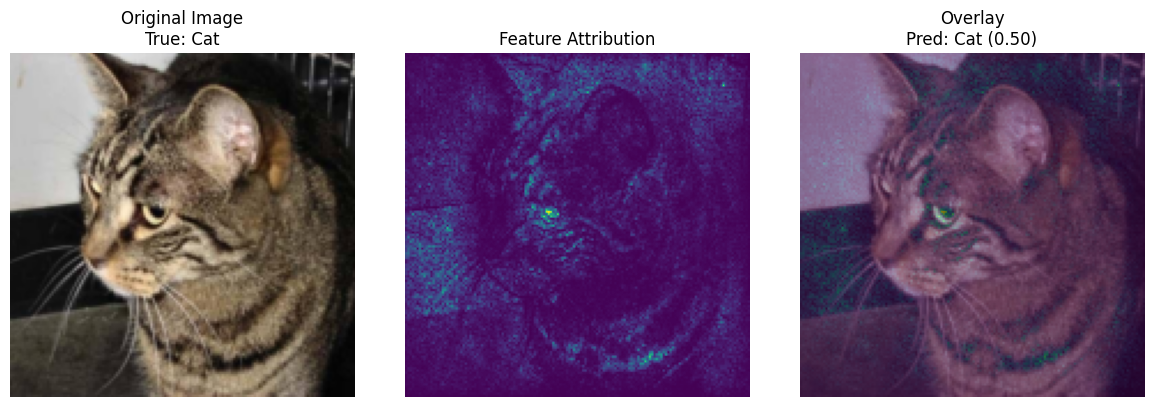

True Label: Cat
Predicted Label: Cat
Prediction Probability: 0.5000


In [125]:
from captum.attr import IntegratedGradients
from torchvision import transforms, datasets
from PIL import Image
import random

def attribute_image_features(model, original_image, device):
    model.eval()

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    transformed_img = transform(original_image).unsqueeze(0).to(device)

    # Define IntegratedGradients
    ig = IntegratedGradients(model)

    # Compute attributions
    attributions = ig.attribute(transformed_img, target=None, return_convergence_delta=False)

    return attributions.squeeze().detach().cpu().numpy()

def visualize_attributions(original_image, attributions, true_label, pred_label, pred_prob):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f'Original Image\nTrue: {true_label}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    attributions = np.transpose(attributions, (1, 2, 0))
    attributions = np.sum(np.abs(attributions), axis=2)
    attributions = (attributions - np.min(attributions)) / (np.max(attributions) - np.min(attributions))
    plt.imshow(attributions, cmap='viridis')
    plt.title('Feature Attribution')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image)
    plt.imshow(attributions, cmap='viridis', alpha=0.5)
    plt.title(f'Overlay\nPred: {pred_label} ({pred_prob:.2f})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load your trained model
model = ConvNet().to(device)
model.load_state_dict(torch.load('cats_and_dogs_small_1.pth', map_location=device))
model.eval()

# Load the train dataset
train_dir = '/content/dogs-vs-cats-subset/train'
train_dataset = datasets.ImageFolder(train_dir, transform=transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
]))

# Choose a random image from the dataset
random_idx = random.randint(0, len(train_dataset) - 1)
original_image, true_label = train_dataset[random_idx]
original_image = transforms.ToPILImage()(original_image)

# Get model prediction
model_input = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(train_dataset[random_idx][0]).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(model_input)
pred_prob = torch.sigmoid(output).item()
pred_label = "Dog" if pred_prob > 0.75 else "Cat"
true_label = "Dog" if true_label == 1 else "Cat"

# Compute attributions
attributions = attribute_image_features(model, original_image, device)

# Visualize the results
visualize_attributions(original_image, attributions, true_label, pred_label, pred_prob)

print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")
print(f"Prediction Probability: {pred_prob:.4f}")

## Grad-CAM (Gradient-weighted Class Activation Mapping)

Grad-CAM is a powerful visualization tool that uses the gradients of a target concept (e.g., a specific class) flowing into the final convolutional layer of a CNN to produce a heatmap highlighting the regions in the image that are most important for the prediction.

We will use Grad-CAM to visualize which parts of the image were most influential in the model’s decision to classify it as a "Dog" or "Cat."
---
The Grad-CAM output shows that the model correctly focuses on the dogs when making its prediction, with strong activations on their bodies. However, some irrelevant areas, such as parts of the floor, are also highlighted, indicating minor misfocus. The model's confidence in predicting the "Dog" class is 0.73, suggesting reasonable certainty. The feature map activations in layer 3 show strong activations in the correct regions, corresponding to the dogs.

Visualizing GradCAM:


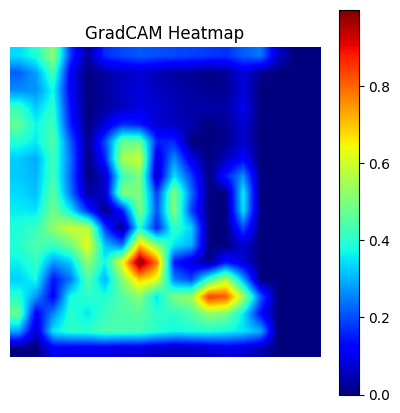

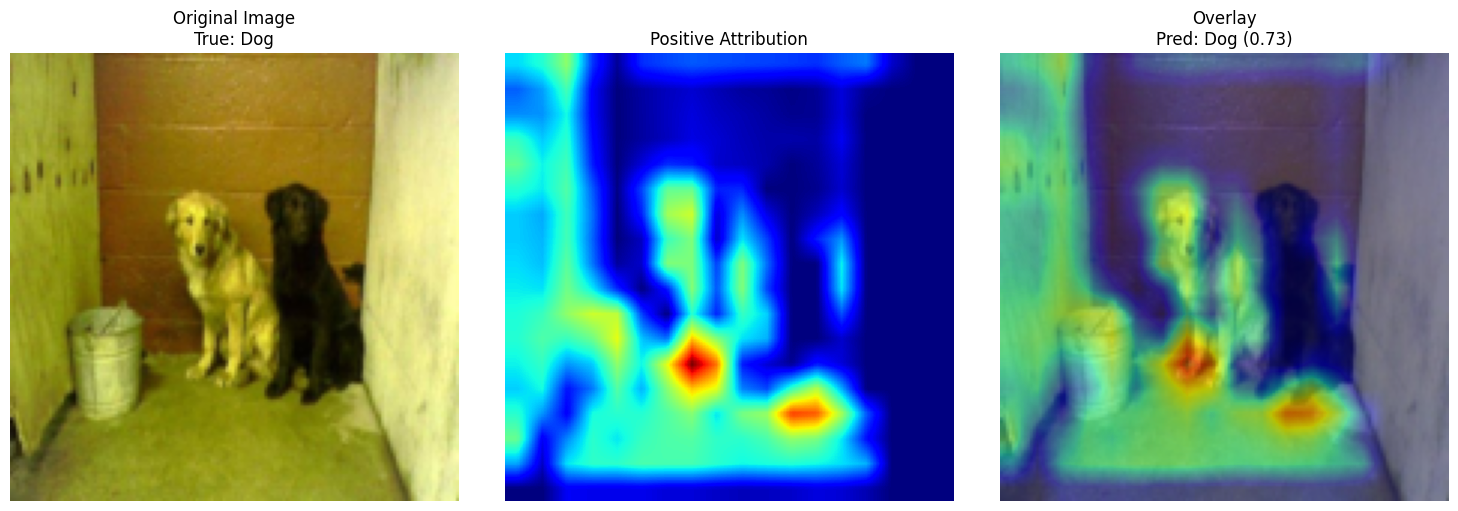

Visualizing Feature Map Activations:


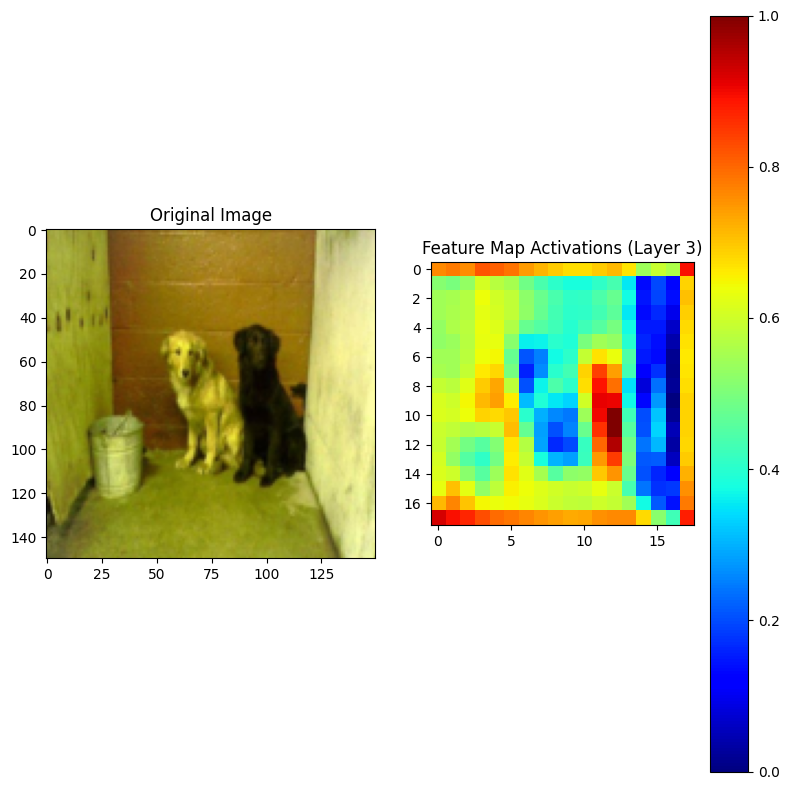

In [150]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


# Function to retrieve a specific convolutional layer by index
def get_specific_conv_layer(model, layer_number):
    conv_layers = [module for module in model.modules() if isinstance(module, nn.Conv2d)]
    if layer_number < 0 or layer_number >= len(conv_layers):
        raise ValueError(f"Layer number {layer_number} is out of range. The model has {len(conv_layers)} convolutional layers.")
    return conv_layers[layer_number]


# Function to compute GradCAM attributions
def attribute_image_features_gradcam(model, original_image, device, layer_number=3):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    transformed_img = transform(original_image).unsqueeze(0).to(device)

    target_layer = get_specific_conv_layer(model, layer_number)
    cam = GradCAM(model=model, target_layers=[target_layer])

    targets = [ClassifierOutputTarget(0)]
    grayscale_cam = cam(input_tensor=transformed_img, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    return grayscale_cam


# Function to compute feature map activations from a specific layer
def compute_layer_activations(model, image, device, layer_number=3):
    model.eval()
    image = image.unsqueeze(0).to(device)

    activations = []
    def hook_fn(module, input, output):
        activations.append(output)

    target_layer = get_specific_conv_layer(model, layer_number)
    hook = target_layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(image)

    hook.remove()

    return activations[0]


# Visualization function for GradCAM
def visualize_gradcam(original_image, attributions, true_label, pred_label, pred_prob):
    np_image = np.array(original_image) / 255.0
    heatmap = show_cam_on_image(np_image, attributions, use_rgb=True)

    plt.figure(figsize=(5, 5))
    plt.imshow(attributions, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.colorbar()
    plt.axis('off')
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image)
    axs[0].set_title(f'Original Image\nTrue: {true_label}')
    axs[0].axis('off')

    axs[1].imshow(attributions, cmap='jet')
    axs[1].set_title('Positive Attribution')
    axs[1].axis('off')

    axs[2].imshow(np_image)
    axs[2].imshow(attributions, cmap='jet', alpha=0.5)
    axs[2].set_title(f'Overlay\nPred: {pred_label} ({pred_prob:.2f})')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


# Visualization function for feature map activations
def visualize_feature_maps(activations, original_image, layer_number=3):
    mean_activations = torch.mean(activations, dim=1).squeeze().cpu().numpy()
    mean_activations = (mean_activations - np.min(mean_activations)) / (np.max(mean_activations) - np.min(mean_activations))

    original_image = original_image.permute(1, 2, 0).cpu().numpy()
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mean_activations, cmap='jet')
    plt.title(f"Feature Map Activations (Layer {layer_number})")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


# Load a random image from the dataset
def get_random_image(dataset, device):
    random_idx = np.random.randint(0, len(dataset) - 1)
    image, label = dataset[random_idx]
    return image.to(device), label


# Main workflow for visualizing both GradCAM and Feature Maps on the same image
def process_image_with_both_visualizations(model, dataset, device, layer_number=3):
    # Get a random image and its true label
    original_image, true_label = get_random_image(dataset, device)
    original_image_pil = transforms.ToPILImage()(original_image.cpu())

    # GradCAM visualization
    gradcam_attributions = attribute_image_features_gradcam(model, original_image_pil, device, layer_number=layer_number)

    # Get model prediction
    model_input = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(original_image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(model_input)
    pred_prob = torch.sigmoid(output).item()
    pred_label = "Dog" if pred_prob > 0.5 else "Cat"
    true_label = "Dog" if true_label == 1 else "Cat"

    # Visualize GradCAM
    print("Visualizing GradCAM:")
    visualize_gradcam(original_image_pil, gradcam_attributions, true_label, pred_label, pred_prob)

    # Compute and visualize feature maps
    activations = compute_layer_activations(model, original_image, device, layer_number=layer_number)
    print("Visualizing Feature Map Activations:")
    visualize_feature_maps(activations, original_image, layer_number=layer_number)

process_image_with_both_visualizations(model, train_dataset, device, layer_number=3)

# Conclusion

In this notebook, we explored several methods to interpret the predictions of a CNN. Each explainer method provided insights into the areas of the image that were most influential in the model’s decision-making process.

- **Integrated Gradients** helped us see the cumulative contribution of each pixel.
- **Grad-CAM** provided a class-specific heatmap showing important areas in the image for the final prediction.

Understanding these techniques not only helps in debugging and improving models but also promotes transparency and trust in AI models.
